## Reciprocal connections as a metric of complexity 

We analyze reciprocal connection densities across neighborhoods in 

* MICrONS data set of the IARPA MICrONS mm^3 dataset https://www.microns-explorer.org/cortical-mm3
* The V5 version of the Blue Brain Project model of https://www.cell.com/fulltext/S0092-8674(15)01191-5

The data used here was generated using `../code/rc_MICrONS.py` and `../code/rc_BBP.py`

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
from scipy import stats 
import pickle

In [2]:
# Load precomputed data 
root='/gpfs/bbp.cscs.ch/home/egassant/reliability_and_structure/data_analysis/data/'
connectomes=['MICrONS', 'BBP']
base_graphs=['original', 'distance', 'ER']
data={conn:{} for conn in connectomes}
for conn in connectomes: 
    for base_graph in ['original', 'distance','ER']:
        data[conn][f'df_{base_graph}']=pd.read_pickle(f'{root}props_{conn}_{base_graph}.pkl')
        data[conn][f'df_{base_graph}_CM']=pd.read_pickle(f'{root}props_{conn}_{base_graph}_CM.pkl')

    # For additional visualization of top/bottom neighborhoods
    for base_graph in base_graphs:
        data[conn][f'sc_{base_graph}']=pd.read_pickle(f'{root}props_{conn}_simplex_counts_{base_graph}.pkl')    
# Removing extreme outliers 
conn='MICrONS'
for base_graph in base_graphs:
    data[conn][f'df_{base_graph}']=data[conn][f'df_{base_graph}'].drop(2294).drop(460)
    

In [44]:
# Plotting functions 
def regress_and_plot(ax, df, base_prop, prop, scatter_kws={'alpha':0.1, 's':10}, color="C0", label_pre=''): 
    x=df[base_prop]; y=df[prop] 
    mask=np.logical_and(~np.isnan(y), ~np.isnan(x))
    regress=stats.linregress(x[mask],y[mask])
    sns.regplot(data=df, x=base_prop, y=prop, scatter_kws=scatter_kws, ax=ax, label=f'{label_pre} r: {regress.rvalue:.3f}', color=color)
    ax.set_ylabel('');     ax.set_xlabel('')
    return ax

def scatter_ori_and_ctr(ax, conn, base_prop, prop, scatter_kws):
    for k, base_graph in enumerate(base_graphs):
        df=data[conn][f'df_{base_graph}']
        ax=regress_and_plot(ax, df, base_prop, prop, label_pre='',
                            scatter_kws=scatter_kws, color=colors[conn][base_graph])         
        
def plot_outliers(axes, base_prop, q=0.01,
                  props = ['euclidean_edges_sc', 'wasserstein_deg_total'],  base_graph='original'):
    # Organize data into DataFrame for seaborn 
    champs=[]
    for conn in connectomes:
        df=data[conn][f'df_{base_graph}']
        top=df[df[base_prop]>=df.quantile(1-q)[base_prop]][props]
        top["type"]="top"
        bottom=df[df[base_prop]<=df.quantile(q)[base_prop]][props]
        bottom["type"]="bottom"
        tb=pd.concat([top, bottom])
        tb["connectome"]=conn
        champs.append(tb)
    champs=pd.concat(champs)
    for i, prop in enumerate(props):
        sns.violinplot(champs, x="connectome", y=prop, hue="type",ax=axes[i], split=True, 
                   palette=colors, inner="quartile", saturation=0.5, linewidth=0.5)

In [59]:
# Font sizes and color and marker schemes
titlesize=8
labelsize=6
ticksize=4
marker_size=2
conversion=2.54
#conversion=1.5
scatter_kws={'alpha':0.1, 's':2}

cmapM=plt.cm.tab20b(np.linspace(0.25,1, 3))
cmapB=plt.cm.tab20c(np.linspace(0.3,1, 3))
colors={
    'MICrONS':{ 
        'original':cmapM[2], 
        'distance':cmapM[1], 
        'ER': cmapM[0]
    },
    'BBP':{
        'original':cmapB[2],
        'distance':cmapB[1], 
        'ER': cmapB[0]
    },
    'top':"firebrick",
    'bottom':"steelblue",
}

cmapM=plt.cm.Dark2
cmapB=plt.cm.Dark2
colors={
    'MICrONS':{ 
        'original':cmapM(0), 
        'distance':cmapM(2), 
        'ER': cmapM(5)
    },
    'BBP':{
        'original':cmapB(0),
        'distance':cmapB(2), 
        'ER': cmapB(5)
    },
    'top':"firebrick",
    'bottom':"steelblue",
}

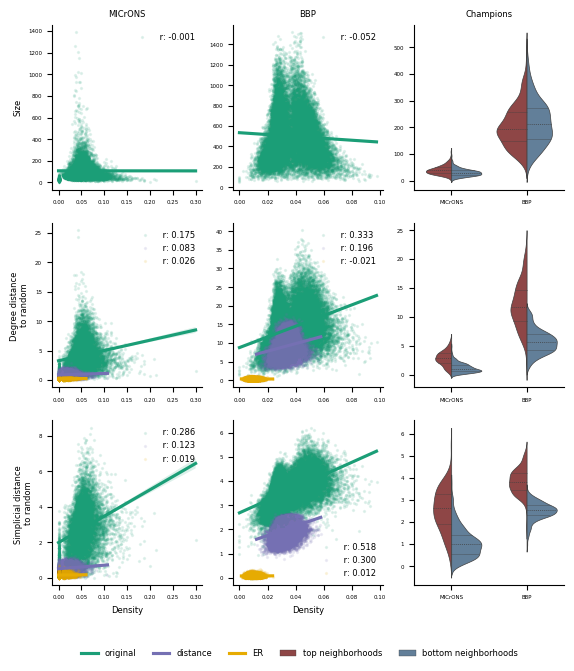

In [61]:
# Option 0
width=21*0.8/conversion
rows, cols = 3, 3
base_prop='rc_over_edges'#'rc_over_nodes'
fig, axs =plt.subplots(rows,cols,figsize=(width, width*rows*1.1/cols))

# Correlation with nbd size
i=0
base_graph='original'; k=0
for j, conn in enumerate(connectomes):
    df=data[conn][f'df_{base_graph}']
    #rc over nodes 
    axs[i, j]=regress_and_plot(axs[i,j], df, base_prop, 'nbd_size', 
                               scatter_kws=scatter_kws, color=colors[conn][base_graph])
    # labels and legends 
    axs[i, j].set_title(conn, fontsize=labelsize);
    axs[i, 0].set_ylabel("Size", fontsize=labelsize)

# Distances to CM 
for i, prop in enumerate(['wasserstein_deg_total', 'euclidean_edges_sc']):
#for i, prop in enumerate(['wasserstein_deg_total']):
    for j, conn in enumerate(connectomes):
        scatter_ori_and_ctr(axs[i+1,j], conn, base_prop, prop, scatter_kws)
        axs[2, j].set_xlabel("Density", fontsize=labelsize)

axs[1, 0].set_ylabel("Degree distance \nto random", fontsize=labelsize)
axs[2, 0].set_ylabel("Simplicial distance \nto random", fontsize=labelsize)

for ax in axs[:,:-1].flatten():
    ax.legend(frameon=False,fontsize=labelsize)


#Outliers 
j=2
props=["nbd_size", "wasserstein_deg_total", "euclidean_edges_sc"]
plot_outliers([axs[0,j], axs[1,j], axs[2,j]], base_prop, props=props)
axs[0, j].set_title("Champions", fontsize=labelsize);
for i in range(3): 
    axs[i,j].get_legend().remove()
    axs[i,j].set_ylabel("", fontsize=labelsize)
    axs[i,j].set_xlabel("", fontsize=labelsize)

# Adding legends  
handles=(axs[1,0].get_lines()+axs[1,2].patches)
fig.legend(handles=handles, labels=base_graphs+["top neighborhoods", "bottom neighborhoods"], 
           frameon=False, ncols=5, loc=8, bbox_to_anchor=(0.5,0),fontsize=labelsize)
for ax in axs.flatten():
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(axis='both', labelsize=ticksize)
fig.savefig("figs/rc_complexity_v0.pdf", transparent=True, bbox_inches='tight')

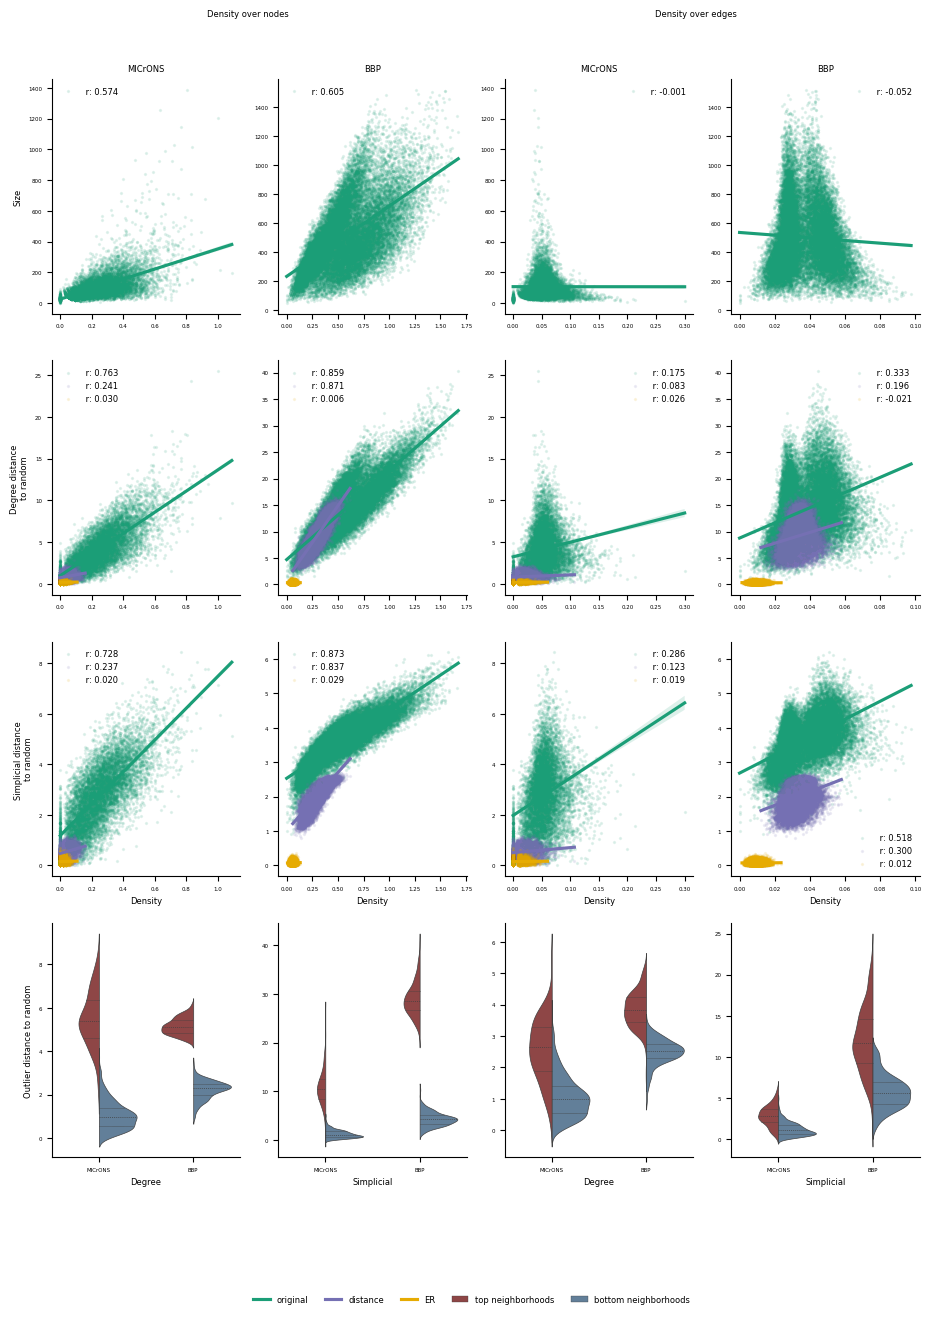

In [46]:
# Make Figure
width=21*0.8/conversion
mosaic = [['s_a', 's_b','s_c', 's_d'],
          ['dd_a', 'dd_b','dd_c', 'dd_d'],
          ['dc_a', 'dc_b','dc_c', 'dc_d'],
          ['out_N1', 'out_N2','out_E1', 'out_E2']]
fig, axes =plt.subplot_mosaic(mosaic,figsize=(width, width*1.25))
#axs=np.array([axes[key] for key in list(axes.keys())[:4*3]]).reshape(3,4)# For easy handling
axs=np.array([axes[key] for key in list(axes.keys())]).reshape(4,4)# Eliminate mosaic if not necessary

# Correlation with nbd size
i=0
base_graph='original'; k=0
for j, conn in enumerate(connectomes):
    df=data[conn][f'df_{base_graph}']
    #rc over nodes 
    axs[i, j]=regress_and_plot(axs[i,j], df, 'rc_over_nodes', 'nbd_size', 
                               scatter_kws=scatter_kws, color=colors[conn][base_graph])
    #rc over edges
    axs[i, j+2]=regress_and_plot(axs[i,j+2], df, 'rc_over_edges', 'nbd_size',  
                                 scatter_kws=scatter_kws, color=colors[conn][base_graph])
    # label and legends 
    axs[i, j].set_title(conn, fontsize=labelsize); axs[i, j+2].set_title(conn, fontsize=labelsize)
    axs[i, 0].set_ylabel("Size", fontsize=labelsize)

# Distances to CM 
for i, prop in enumerate(['wasserstein_deg_total', 'euclidean_edges_sc']):
#for i, prop in enumerate(['wasserstein_deg_total']):
    for j, conn in enumerate(connectomes):
        for l, base_prop in enumerate(['rc_over_nodes','rc_over_edges']):
        #for l, base_prop in enumerate(['rc_over_nodes']):
            scatter_ori_and_ctr(axs[i+1,j+l*2], conn, base_prop, prop, scatter_kws)
            axs[2, j+l*2].set_xlabel("Density", fontsize=labelsize)

axs[1, 0].set_ylabel("Degree distance \nto random", fontsize=labelsize)
axs[2, 0].set_ylabel("Simplicial distance \nto random", fontsize=labelsize)

for ax in axs[:-1,:].flatten():
    ax.legend(frameon=False,fontsize=labelsize); axs[0, j+2].legend(frameon=False,fontsize=labelsize)


#Outliers 
i=3
#axes['out_N1'].set_ylabel("Outliers", fontsize=labelsize)
for l, base_prop in enumerate(['rc_over_nodes', 'rc_over_edges']):
    plot_outliers([axs[i,0+l*2], axs[i,1+l*2]], base_prop)

# Labels and legends 
axs[i,0].legend(frameon=False, fontsize=labelsize)
axs[i,0].get_legend().remove()

for k in np.arange(3)+1: 
    axs[i,k].get_legend().remove()
    axs[i,k].set_ylabel("", fontsize=labelsize)
axs[i,0].set_ylabel("Outlier distance to random", fontsize=labelsize)
for l in range(2): 
    axs[i,l*2].set_xlabel("Degree", fontsize=labelsize)
    axs[i,1+l*2].set_xlabel("Simplicial", fontsize=labelsize)

# Adding legends  
handles=(axs[1,1].get_lines()+axs[-1,0].patches)
fig.legend(handles=handles, labels=base_graphs+["top neighborhoods", "bottom neighborhoods"], 
           frameon=False, ncols=5, loc=8, bbox_to_anchor=(0.5,0),fontsize=labelsize)
fig.text(0.3,0.925,'Density over nodes', fontsize=labelsize, ha='center')
fig.text(0.7,0.925,'Density over edges', fontsize=labelsize, ha='center')

    

for key in axes.keys():
    axes[key].spines[["top", "right"]].set_visible(False)
    axes[key].tick_params(axis='both', labelsize=ticksize)
fig.savefig("figs/rc_complexity.pdf", transparent=True, bbox_inches='tight')